In [2]:
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'


Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



In [3]:
import torch

Create a tensor and set ``requires_grad=True`` to track computation with it



In [4]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation:



In [5]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [6]:
print(y.grad_fn)

Do more operations on ``y``



In [7]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.



In [8]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


Gradients
---------
Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.



In [9]:
out.backward()

Print gradients d(out)/dx




In [10]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.



Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$,
then the gradient of $\vec{y}$ with respect to $\vec{x}$
is a Jacobian matrix:

\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector
$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$,
compute the product $v^{T}\cdot J$. If $v$ happens to be
the gradient of a scalar function $l=g\left(\vec{y}\right)$,
that is,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$,
then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

(Note that $v^{T}\cdot J$ gives a row vector which can be
treated as a column vector by taking $J^{T}\cdot v$.)

This characteristic of vector-Jacobian product makes it very
convenient to feed external gradients into a model that has
non-scalar output.


$J \times v_1$ 表示函数 $f$ 在 $x$ 空间沿着 $v_1$ 方向的方向导数，即 $x$ 沿着 $v_1$ 变化时，$f$ 的变化率。

而 $v^\top \times J$ 表示 $y$ 空间沿着 $v$ 变化时，对 $x$ 的影响，并不是严格意义上的方向导数，但在反向传播中具有重要作用。



Now let's take a look at an example of vector-Jacobian product:



In [11]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ -90.6690, -686.1023, 1475.3444], grad_fn=<MulBackward0>)


Now in this case ``y`` is no longer a scalar. ``torch.autograd``
could not compute the full Jacobian directly, but if we just
want the vector-Jacobian product, simply pass the vector to
``backward`` as argument:



In [12]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


You can also stop autograd from tracking history on Tensors
with ``.requires_grad=True`` either by wrapping the code block in
``with torch.no_grad():``



In [13]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
	print((x ** 2).requires_grad)

True
True
False


Or by using ``.detach()`` to get a new Tensor with the same
content but that does not require gradients:



In [14]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


**Read Later:**

Document about ``autograd.Function`` is at
https://pytorch.org/docs/stable/autograd.html#function



In [1]:
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
# Create tensors of shape (10, 3) and (10, 2).
x = torch.randn(10, 3)
y = torch.randn(10, 2)

NameError: name 'torch' is not defined

In [13]:
# Build a fully connected layer.
linear = nn.Linear(3, 2)
print ('w: ', linear.weight)
print ('b: ', linear.bias)

w:  Parameter containing:
tensor([[ 0.4233, -0.0946, -0.0834],
        [-0.5024, -0.2206, -0.3390]], requires_grad=True)
b:  Parameter containing:
tensor([ 0.2659, -0.3096], requires_grad=True)


In [14]:
# Build loss function and optimizer.
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

In [15]:
# Forward pass.
pred = linear(x)

In [16]:
# Compute loss.
loss = criterion(pred, y)
print('loss: ', loss.item())

loss:  2.924147129058838


In [17]:
# Backward pass.
loss.backward()

In [18]:
# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

dL/dw:  tensor([[ 0.5613,  0.3147,  0.6846],
        [-1.6986, -0.3663, -0.8149]])
dL/db:  tensor([ 0.5913, -0.1180])


In [19]:
# 1-step gradient descent.
optimizer.step()

In [20]:
# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('loss after 1 step optimization: ', loss.item())

loss after 1 step optimization:  2.8751773834228516


In [21]:
# ================================================================== #
#                     3. Loading data from numpy                     #
# ================================================================== #

# Create a numpy array.
x = np.array([[1, 2], [3, 4]])

# Convert the numpy array to a torch tensor.
y = torch.from_numpy(x)

# Convert the torch tensor to a numpy array.
z = y.numpy()

In [24]:
# Download and construct CIFAR-10 dataset.
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)


Files already downloaded and verified


In [25]:
# Fetch one data pair (read data from disk).
image, label = train_dataset[0]
print (image.size())
print (label)


torch.Size([3, 32, 32])
6


In [26]:
# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)


In [27]:
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

In [28]:
# Mini-batch images and labels.
images, labels = data_iter.next()

In [29]:
import matplotlib.pyplot as plt

In [30]:
# Hyper-parameters
input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

In [31]:
# Toy dataset
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)


In [32]:
# Linear regression model
model = nn.Linear(input_size, output_size)

In [33]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [34]:
# Train the model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [5/60], Loss: 21.3229
Epoch [10/60], Loss: 8.7402
Epoch [15/60], Loss: 3.6427
Epoch [20/60], Loss: 1.5776
Epoch [25/60], Loss: 0.7411
Epoch [30/60], Loss: 0.4021
Epoch [35/60], Loss: 0.2648
Epoch [40/60], Loss: 0.2092
Epoch [45/60], Loss: 0.1867
Epoch [50/60], Loss: 0.1775
Epoch [55/60], Loss: 0.1738
Epoch [60/60], Loss: 0.1723


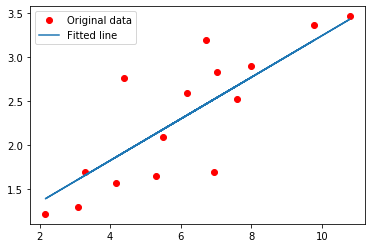

In [35]:
# Plot the graph
predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

In [36]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [37]:
#### feedforward_neural_network

In [38]:
# Hyper-parameters 
input_size = 28*28
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [39]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [40]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [42]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [43]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 0.4459
Epoch [1/5], Step [200/600], Loss: 0.2850
Epoch [1/5], Step [300/600], Loss: 0.2269
Epoch [1/5], Step [400/600], Loss: 0.2231
Epoch [1/5], Step [500/600], Loss: 0.1532
Epoch [1/5], Step [600/600], Loss: 0.2710
Epoch [2/5], Step [100/600], Loss: 0.1489
Epoch [2/5], Step [200/600], Loss: 0.3242
Epoch [2/5], Step [300/600], Loss: 0.0676
Epoch [2/5], Step [400/600], Loss: 0.1021
Epoch [2/5], Step [500/600], Loss: 0.1104
Epoch [2/5], Step [600/600], Loss: 0.1063
Epoch [3/5], Step [100/600], Loss: 0.1364
Epoch [3/5], Step [200/600], Loss: 0.0564
Epoch [3/5], Step [300/600], Loss: 0.0538
Epoch [3/5], Step [400/600], Loss: 0.0471
Epoch [3/5], Step [500/600], Loss: 0.0753
Epoch [3/5], Step [600/600], Loss: 0.0154
Epoch [4/5], Step [100/600], Loss: 0.0461
Epoch [4/5], Step [200/600], Loss: 0.0333
Epoch [4/5], Step [300/600], Loss: 0.1161
Epoch [4/5], Step [400/600], Loss: 0.0276
Epoch [4/5], Step [500/600], Loss: 0.0704
Epoch [4/5], Step [600/600], Loss:

In [44]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Accuracy of the network on the 10000 test images: 97.74 %
